In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import sklearn.preprocessing

from helpers import *

global result_dir

# Brute
def brute_single_search_time(algo, test_vector, ground_truth_vector, max_k, n=100):
    query_times = []
    last_recall = 0
    
    for search_count in range(1, max_k+1):
        if last_recall == 1:
            break

        query_result = algo.knn_query(test_vector, search_count)[0]
        new_recall = (np.isin(query_result, ground_truth_vector).sum() / ground_truth_vector.size)

        if new_recall > last_recall:
            query_time_list = []
            for i in range(n):
                start_time = time.time_ns()
                query_result = algo.knn_query(test_vector, search_count)[0]
                query_time = time.time_ns() - start_time

                query_time_list.append(query_time)

            last_recall = new_recall
            query_times.append([new_recall, np.mean(query_time_list), search_count])
    
    return query_times

def brute_multiple_search_time(algo, list_of_test_labels, list_of_test_vectors, list_of_ground_truth_vectors, max_k, n=100):
    results = {}
    for i in range(len(list_of_test_labels)):
        results[list_of_test_labels[i]] = (brute_single_search_time(algo, list_of_test_vectors[i], list_of_ground_truth_vectors[i], max_k, n))
    return results
#===============================================================
# Annoy
def annoy_single_search_time(algo, test_vector, ground_truth_vector, max_k, n=100):
    query_times = []
    last_recall = 0
    
    for search_count in range(1, max_k+1):
        if last_recall == 1:
            break

        start_time = time.time_ns()
        query_result = algo.get_nns_by_vector(test_vector, search_count)
        query_time = time.time_ns() - start_time

        new_recall = (np.isin(query_result, ground_truth_vector).sum() / ground_truth_vector.size)

        if new_recall > last_recall:
            query_time_list = []
            for i in range(n):
                start_time = time.time_ns()
                query_result = algo.get_nns_by_vector(test_vector, search_count)[0]
                query_time = time.time_ns() - start_time

                query_time_list.append(query_time)
            
            last_recall = new_recall
            query_times.append([new_recall, np.mean(query_time_list), search_count])

    return query_times

def annoy_multiple_search_time(algo, list_of_test_labels, list_of_test_vectors, list_of_ground_truth_vectors, max_k, n=100):
    results = {}
    for i in range(len(list_of_test_labels)):
        results[list_of_test_labels[i]] = (annoy_single_search_time(algo, list_of_test_vectors[i ], list_of_ground_truth_vectors[i], max_k, n))
    return results
#===============================================================
# HNSW
def hnsw_single_search_time(algo, test_vector, ground_truth_vector, max_k, n=100):
    query_times = []
    last_recall = 0
    
    for search_count in range(1, max_k+1):
        if last_recall == 1:
            break

        start_time = time.time_ns()
        query_result = algo.knn_query(test_vector, search_count)[0]
        query_time = time.time_ns() - start_time

        new_recall = (np.isin(query_result, ground_truth_vector).sum() / ground_truth_vector.size)

        if new_recall > last_recall:
            last_recall = new_recall

            query_time_list = []
            for i in range(n):
                start_time = time.time_ns()
                query_result = algo.knn_query(test_vector, search_count)[0]
                query_time = time.time_ns() - start_time

                query_time_list.append(query_time)
            
            query_times.append([new_recall, np.mean(query_time_list), search_count])
    
    return query_times

def hnsw_multiple_search_time(algo, list_of_test_labels, list_of_test_vectors, list_of_ground_truth_vectors, max_k, n=100):
    results = {}
    for i in range(len(list_of_test_labels)):
        results[list_of_test_labels[i]] = (hnsw_single_search_time(algo, list_of_test_vectors[i ], list_of_ground_truth_vectors[i], max_k, n))
    return results
#===============================================================
# FLANN
def flann_single_search_time(algo, test_vector, ground_truth_vector, max_k, n=100):
    query_times = []
    last_recall = 0

    if test_vector.dtype != np.float32:
        test_vector = test_vector.astype(np.float32)
    
    for search_count in range(1, max_k+1):
        if last_recall == 1:
            break

        start_time = time.time_ns()
        query_result = algo.nn_index(test_vector, num_neighbors=search_count)[0][0]
        query_time = time.time_ns() - start_time

        new_recall = (np.isin(query_result, ground_truth_vector).sum() / ground_truth_vector.size)

        if new_recall > last_recall:
            last_recall = new_recall

            query_time_list = []
            for i in range(n):
                start_time = time.time_ns()
                query_result = algo.nn_index(test_vector, search_count)[0][0]
                query_time = time.time_ns() - start_time

                query_time_list.append(query_time)
            
            query_times.append([new_recall, np.mean(query_time_list), search_count])
    
    return query_times

def flann_multiple_search_time(algo, list_of_test_labels, list_of_test_vectors, list_of_ground_truth_vectors, max_k, n=100):
    results = {}
    for i in range(len(list_of_test_labels)):
        results[list_of_test_labels[i]] = (flann_single_search_time(algo, list_of_test_vectors[i ], list_of_ground_truth_vectors[i], max_k, n))
    return results

#==============================================
def dict_to_dataframe(data):
    df = pd.DataFrame.from_dict({(i,j[2]):[i]+j[:2] for i in data.keys() for j in data[i]}, orient='index', columns=['test_key', 'recall', 'avg_query_time'])
    df.index.names = ['k']
    df = df.reset_index()
    df['k'] = df['k'].apply(lambda x: x[1])
    return df


In [2]:
class ANNQueryTime:
    def __init__(self, dataset_name, max_k_search, metric, result_dir):
        self.dataset_name = dataset_name
        self.dataset_name = dataset_name
        self.max_k_search = max_k_search
        self.metric = metric
        self.result_dir = result_dir

        self.train, self.test, self.dim = load_and_transform_dataset(self.dataset_name)
        if self.metric == 'cosine':
            self.train = sklearn.preprocessing.normalize(self.train, axis=1, norm="l2")
            self.test = sklearn.preprocessing.normalize(self.test, axis=1, norm="l2")

        print("Dataset Loaded")
        print("="*21)
        self.filename = dataset_name.split('-')[0]

        self.brute_labels = load_exported_results(f'brute_labels_{self.filename}', result_dir)
        self.test_labels = [6980, 6560, 5693, 1116, 378, 4005, 8910, 3254, 543, 7759]
        # self.test_labels = random.sample([x for x in range(0, len(self.test))], 10)

        self.ground_truth_vectors = [self.brute_labels[x] for x in self.test_labels]
        self.test_vectors = [self.test[x] for x in self.test_labels]

    def run_query_time(self):
        print("Running Brute")
        self.brute = brute_load_index(f'brute_index_{self.filename}', self.dim, metric='l2', result_dir=self.result_dir)
        self.brute_query = brute_multiple_search_time(self.brute, self.test_labels, self.test_vectors, self.ground_truth_vectors, self.max_k_search)
        
        print("Running Annoy")
        self.annoy = annoy_load_index(f'annoy_index_{self.filename}', self.dim, metric='l2', result_dir=self.result_dir)
        self.annoy_query = annoy_multiple_search_time(self.annoy, self.test_labels, self.test_vectors, self.ground_truth_vectors, self.max_k_search)
        
        print("Running HNSW")
        self.hnsw = hnsw_load_index(f'hnsw_index_{self.filename}', self.dim, metric='l2', result_dir=self.result_dir)
        self.hnsw_query = hnsw_multiple_search_time(self.hnsw, self.test_labels, self.test_vectors, self.ground_truth_vectors, self.max_k_search)
        
        print("Running FLANN")
        self.flann = flann_load_index(f"flann_index_{self.filename}", self.train, self.result_dir)
        self.flann_query = flann_multiple_search_time(self.flann, self.test_labels, self.test_vectors, self.ground_truth_vectors, self.max_k_search)

        self.export()
        print("Finished")
        
    def export(self):
        self.df_brute = dict_to_dataframe(self.brute_query)
        self.df_brute.to_csv(f"{self.result_dir}/brute_query_res_{self.filename}.csv", index=False)

        self.df_annoy = dict_to_dataframe(self.annoy_query)
        self.df_annoy.to_csv(f"{self.result_dir}/annoy_query_res_{self.filename}.csv", index=False)

        self.df_hnsw = dict_to_dataframe(self.hnsw_query)
        self.df_hnsw.to_csv(f"{self.result_dir}/hnsw_query_res_{self.filename}.csv", index=False)

        self.df_flann = dict_to_dataframe(self.flann_query)
        self.df_flann.to_csv(f"{self.result_dir}/flann_query_res_{self.filename}.csv", index=False)


In [109]:
def plot_query_time_and_avg_k(dataset_name, df_brute_query, list_of_query_dfs, list_of_labels):
    def generate_recall_to_avg_query(df):
        return df.groupby('recall').agg({"avg_query_time":'mean'}).reset_index()

    def generate_avg_k_to_recall(df):
        return df.groupby('recall').agg({"k":'mean'}).reset_index()

    brute_avg_query = np.round(df_brute_query[df_brute_query['recall'] == 1.0]['avg_query_time'].mean() / 1e6, 2)

    recall_to_avg_query_dfs = [generate_recall_to_avg_query(df) for df in list_of_query_dfs]
    avg_k_to_to_recall_dfs = [generate_avg_k_to_recall(df) for df in list_of_query_dfs]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Recall vs Avg Query Time
    for i, df in enumerate(recall_to_avg_query_dfs):
        axes[0].plot(df['avg_query_time'] / 1e6, df['recall'], label=list_of_labels[i])

    axes[0].set_xlabel('Avg Query Time (ms)')
    axes[0].set_ylabel('Recall')
    axes[0].set_title(f'Recall vs. Avg Query Time - {dataset_name}')
    axes[0].legend(title=f'BF: {brute_avg_query} ms')

    # Plot Recall vs Avg K
    for i, df in enumerate(avg_k_to_to_recall_dfs):
        axes[1].plot(df['recall'], df['k'], label=list_of_labels[i])

    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Avg K')
    axes[1].set_title(f'Recall vs. Avg K - {dataset_name}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [31]:
dataset_name = 'mnist-784-euclidean'
metric = 'l2'
result_dir = './result/mnist'
max_k_search = 5000

qt = ANNQueryTime(dataset_name, max_k_search, metric, result_dir)
qt.run_query_time()

df_brute_query = qt.df_brute
df_annoy_query = qt.df_annoy
df_hnsw_query = qt.df_hnsw
df_flann_query = qt.df_flann

Got a train set of size (60000 * 784)
Got 10000 queries
Dataset Loaded
Running Brute
Running Annoy
Running HNSW
Running FLANN
Finished


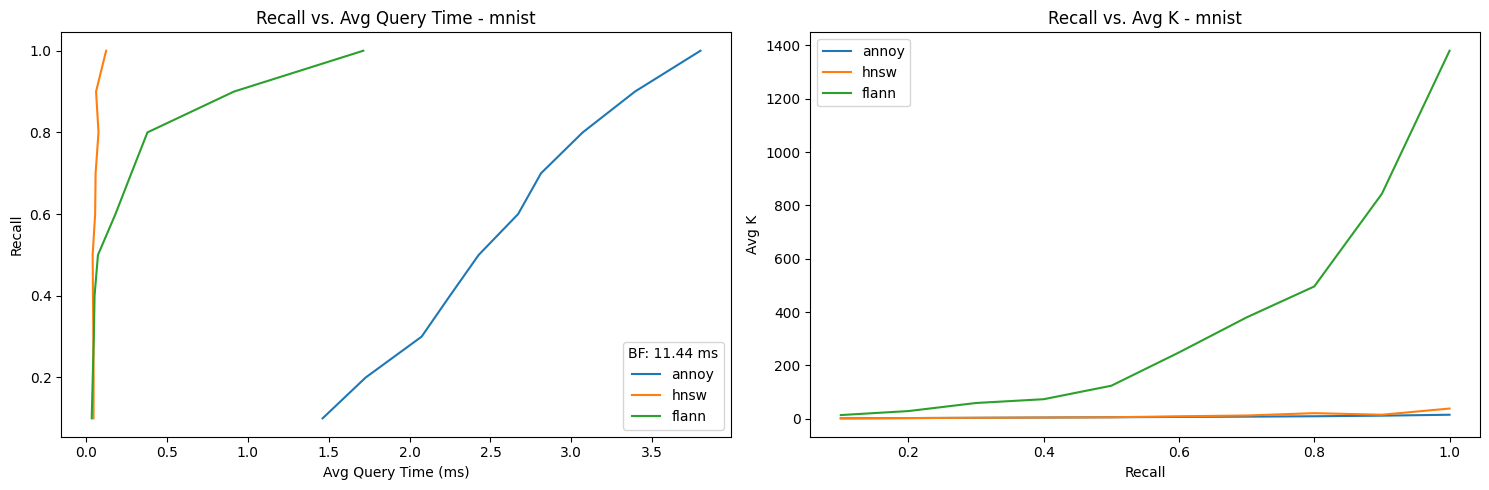

In [32]:
list_of_query_dfs = [df_annoy_query, df_hnsw_query, df_flann_query]
list_of_labels = ["annoy", "hnsw", "flann"]

dataset_name = 'mnist'
plot_query_time_and_avg_k(dataset_name, df_brute_query, list_of_query_dfs, list_of_labels)

In [6]:
dataset_name = 'sift-128-euclidean'
metric = 'l2'
result_dir = './result/sift'
max_k_search = 5000

qt = ANNQueryTime(dataset_name, max_k_search, metric, result_dir)
qt.run_query_time()

df_brute_query = qt.df_brute
df_annoy_query = qt.df_annoy
df_hnsw_query = qt.df_hnsw
df_flann_query = qt.df_flann

Got a train set of size (1000000 * 128)
Got 10000 queries
Dataset Loaded
Running Brute
Running Annoy
Running HNSW
Running FLANN
Finished


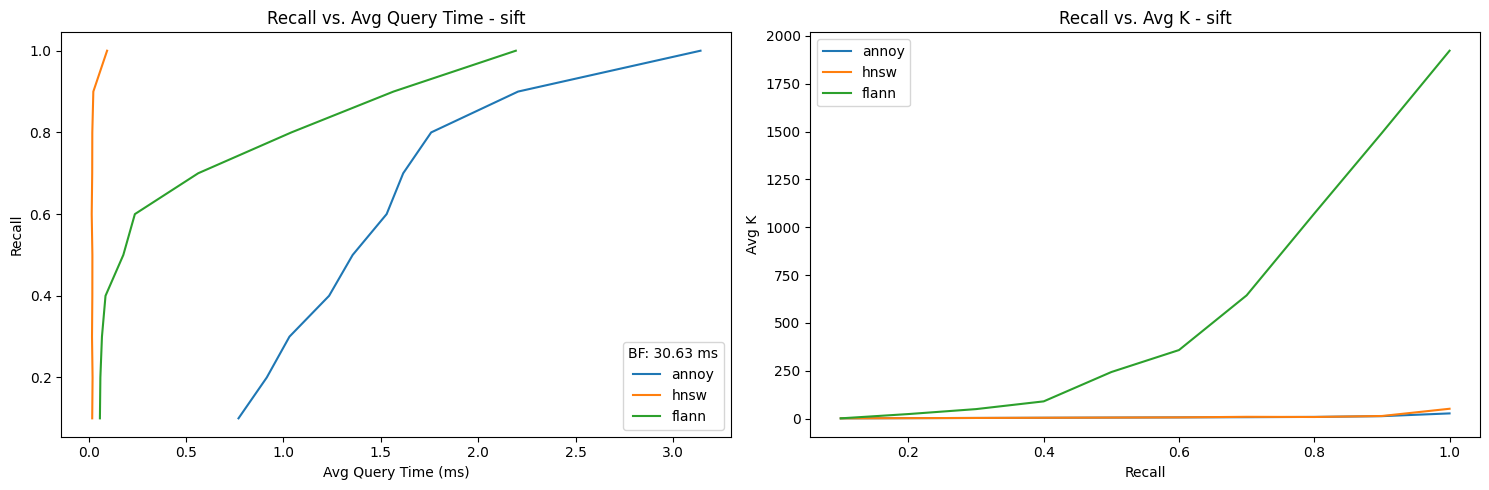

In [48]:
list_of_query_dfs = [df_annoy_query, df_hnsw_query, df_flann_query]
list_of_labels = ["annoy", "hnsw", "flann"]

plot_query_time_and_avg_k(dataset_name.split('-')[0], df_brute_query, list_of_query_dfs, list_of_labels)

In [51]:
dataset_name = 'deep-image-96-euclidean'
metric = 'l2'
result_dir = './result/deep'
max_k_search = 5000

qt = ANNQueryTime(dataset_name, max_k_search, metric, result_dir)
qt.run_query_time()

df_brute_query = qt.df_brute
df_annoy_query = qt.df_annoy
df_hnsw_query = qt.df_hnsw
df_flann_query = qt.df_flann

Got a train set of size (1000000 * 96)
Got 10000 queries
Dataset Loaded
Running Brute
Running Annoy
Running HNSW
Running FLANN
Finished


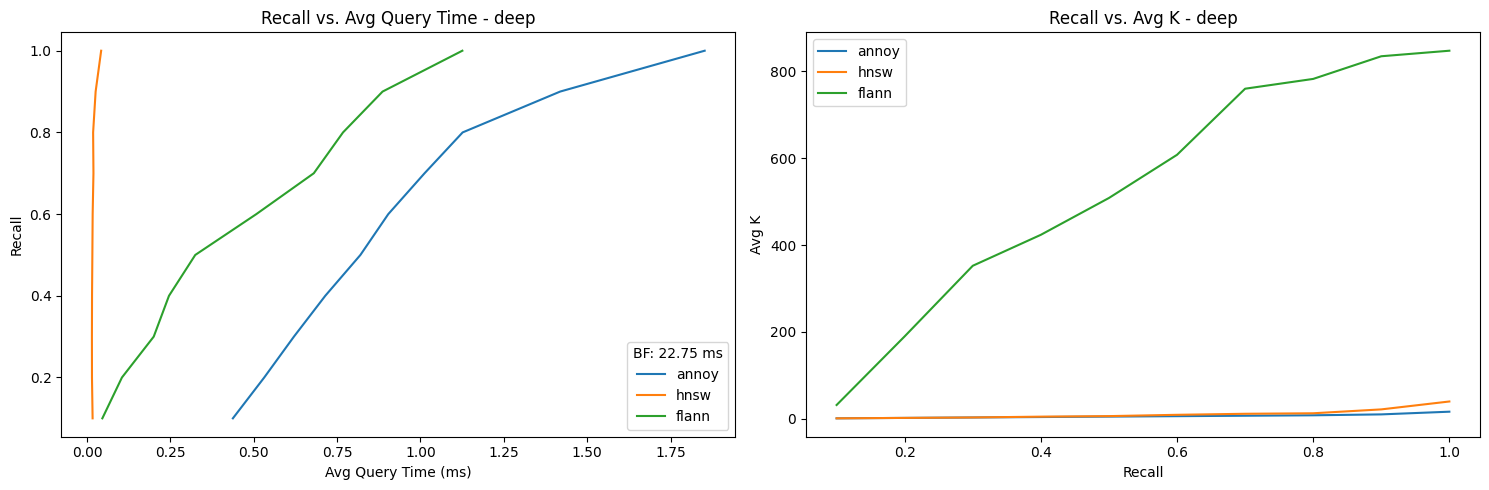

In [72]:
list_of_query_dfs = [df_annoy_query, df_hnsw_query, df_flann_query]
list_of_labels = ["annoy", "hnsw", "flann"]

plot_query_time_and_avg_k(dataset_name.split('-')[0], df_brute_query, list_of_query_dfs, list_of_labels)

In [74]:
dataset_name = 'glove-100-angular'
metric = 'cosine'
result_dir = './result/glove'
max_k_search = 5000

qt = ANNQueryTime(dataset_name, max_k_search, metric, result_dir)
qt.run_query_time()

df_brute_query = qt.df_brute
df_annoy_query = qt.df_annoy
df_hnsw_query = qt.df_hnsw
df_flann_query = qt.df_flann

Got a train set of size (1183514 * 100)
Got 10000 queries
Dataset Loaded
Running Brute
Running Annoy
Running HNSW
Running FLANN
Finished


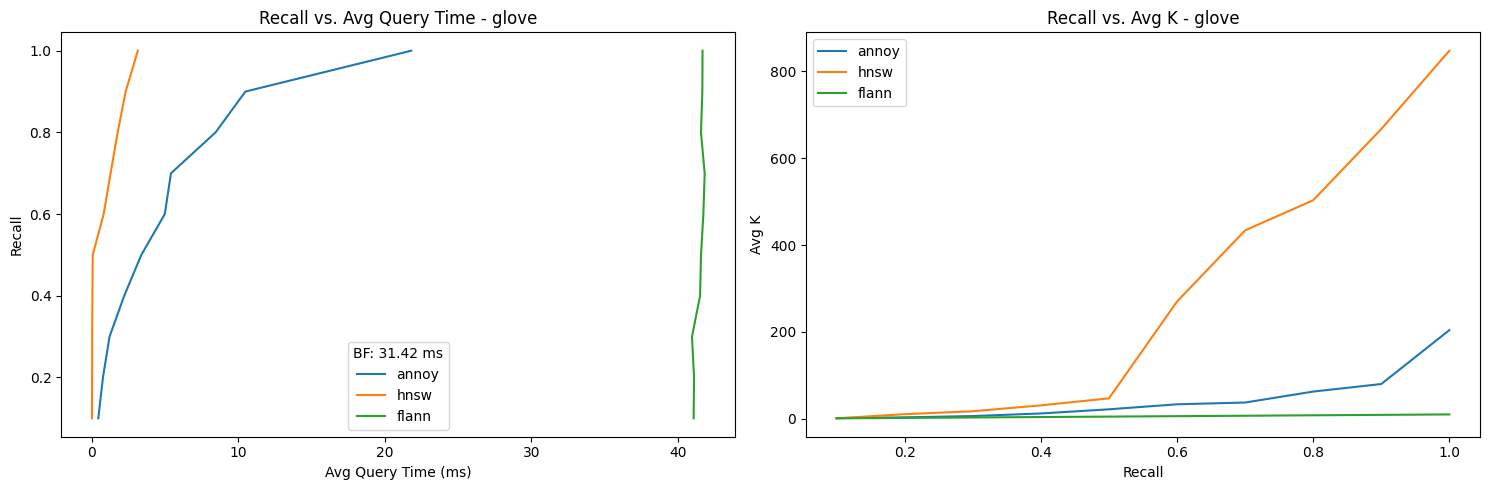

In [110]:
list_of_query_dfs = [df_annoy_query, df_hnsw_query, df_flann_query]
list_of_labels = ["annoy", "hnsw", "flann"]

plot_query_time_and_avg_k(dataset_name.split('-')[0], df_brute_query, list_of_query_dfs, list_of_labels)